In [10]:
pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.9.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.2.1-cp312-cp312-win_amd64.whl (189 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [12]:

class SapotaDataGenerator(Sequence):
    def __init__(self, dataset_path, batch_size, target_size, subset='training'):
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.target_size = target_size
        self.subset = subset
        self.datagen = ImageDataGenerator(rescale=1./255)
        self.image_paths, self.class_labels, self.days = self._get_image_paths_and_labels()
        self.indexes = np.arange(len(self.image_paths))
        if subset == 'training':
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_paths = self.image_paths[start:end]
        
        batch_images = np.zeros((len(batch_paths), *self.target_size, 3), dtype=np.float32)
        batch_labels_category = np.zeros((len(batch_paths), 2), dtype=np.float32) 
        batch_labels_days = np.zeros((len(batch_paths), 4), dtype=np.float32) 

        for i, path in enumerate(batch_paths):
            try:
                img = load_img(path, target_size=self.target_size)
                img = img_to_array(img) / 255.0
                
                batch_images[i] = img
                batch_labels_category[i] = to_categorical(self.class_labels[start + i], num_classes=2)
                batch_labels_days[i] = to_categorical(self.days[start + i] - 2, num_classes=4)  
            except Exception as e:
                print(f"Error loading image {path}: {e}")
                batch_images[i] = np.zeros((*self.target_size, 3))

        return batch_images, {'category_output': batch_labels_category, 'days_output': batch_labels_days}
    
    def on_epoch_end(self):
        if self.subset == 'training':
            np.random.shuffle(self.indexes)
    
    def _get_image_paths_and_labels(self):
        image_paths = []
        class_labels = []
        days = []
        
        for day_dir in sorted(os.listdir(self.dataset_path)):
            day_path = os.path.join(self.dataset_path, day_dir)
            if not os.path.isdir(day_path):
                continue
            for condition in ['Rotten', 'Not Rotten']:
                condition_path = os.path.join(day_path, condition)
                if not os.path.exists(condition_path):
                    print(f"Skipping missing directory: {condition_path}")
                    continue
                for image_name in os.listdir(condition_path):
                    image_path = os.path.join(condition_path, image_name)
                    image_paths.append(image_path)
                    class_labels.append(0 if condition == 'Not Rotten' else 1)
                    days.append(int(day_dir))
    
        return image_paths, class_labels, days
    
    def get_class_labels(self):
        return np.array(self.class_labels)[self.indexes]
    
    def analyze_class_distribution(self):
        class_counts = {'Not Rotten': 0, 'Rotten': 0}
        for label in self.class_labels:
            class_name = 'Not Rotten' if label == 0 else 'Rotten'
            class_counts[class_name] += 1
        return class_counts
    
    def analyze_days_distribution(self):
        days_counter = Counter(self.days)
        return days_counter
    
    def balance_dataset(self):
        for day_dir in os.listdir(self.dataset_path):
            day_path = os.path.join(self.dataset_path, day_dir)
            if not os.path.isdir(day_path):
                continue
            class_counts = self.analyze_class_distribution()
            minority_cls = min(class_counts, key=class_counts.get)
            majority_cls = max(class_counts, key=class_counts.get)
            minority_cls_path = os.path.join(day_path, minority_cls)
            minority_count = class_counts[minority_cls]
            augmentation_factor = (class_counts[majority_cls] - minority_count) // minority_count if minority_count > 0 else 0
            if augmentation_factor > 0:
                self._augment_class_images(minority_cls_path, augmentation_factor)
    
    def _augment_class_images(self, class_path, augmentation_factor):
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=class_path, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= augmentation_factor:
                    break


In [13]:

def create_model(input_shape, num_classes_category, num_classes_days):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    
    category_output = Dense(num_classes_category, activation='softmax', name='category_output')(x)
    days_output = Dense(num_classes_days, activation='softmax', name='days_output')(x)
    
    model = Model(inputs=inputs, outputs=[category_output, days_output])
    
    return model

dataset_path = r'E:\XAMPP\htdocs\Frontend\Backend\Sapota\dataset'
batch_size = 32
target_size = (224, 224) 
epochs = 20

train_generator = SapotaDataGenerator(dataset_path=dataset_path, batch_size=batch_size, target_size=target_size, subset='training')
validation_generator = SapotaDataGenerator(dataset_path=dataset_path, batch_size=batch_size, target_size=target_size, subset='validation')

model = create_model(input_shape=(*target_size, 3), num_classes_category=2, num_classes_days=4)  # Adjust num_classes_days according to your range
model.compile(optimizer='adam', 
              loss={'category_output': 'categorical_crossentropy', 'days_output': 'categorical_crossentropy'}, 
              metrics={'category_output': 'accuracy', 'days_output': 'accuracy'})

history = model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

loss, category_loss, days_loss, category_accuracy, days_accuracy = model.evaluate(
    x=validation_generator,
    steps=len(validation_generator)
)

print("Category Accuracy:", category_accuracy)
print("Days Accuracy:", days_accuracy)


Error loading image E:\XAMPP\htdocs\Frontend\Backend\Sapota\dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000029AEA113F60>
Epoch 1/20


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Error loading image E:\XAMPP\htdocs\Frontend\Backend\Sapota\dataset\2\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000029AEA77ED40>
Error loading image E:\XAMPP\htdocs\Frontend\Backend\Sapota\dataset\3\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000029AEB532750>
 4/75 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - category_output_accuracy: 0.4323 - days_output_accuracy: 0.4792 - loss: 3.1473Error loading image E:\XAMPP\htdocs\Frontend\Backend\Sapota\dataset\3\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000029AEA77FC40>
18/75 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - category_output_accuracy: 0.5866 - days_output_accuracy: 0.5171 - loss: 10.5699Error loading image E:\XAMPP\htdocs\Frontend\Backend\Sapota\dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000029AEA78C0E0>
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - category_output_accuracy: 0.7100 - days_output_accuracy: 0.5916 - loss: 5.9691E

c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
model.save("cnn.h5")

C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


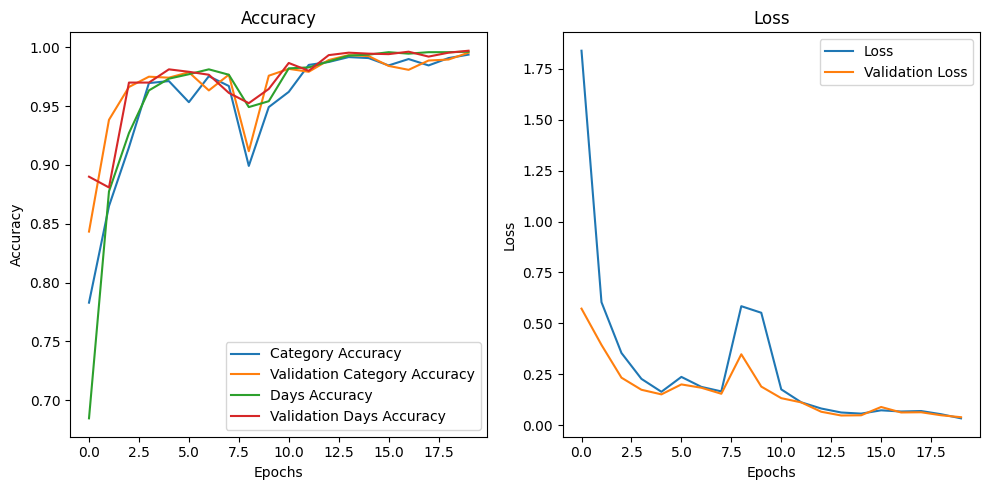

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['category_output_accuracy'], label='Category Accuracy')
plt.plot(history.history['val_category_output_accuracy'], label='Validation Category Accuracy')
plt.plot(history.history['days_output_accuracy'], label='Days Accuracy')
plt.plot(history.history['val_days_output_accuracy'], label='Validation Days Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
def accumulate_labels(generator, steps):
    all_labels_category = []
    all_labels_days = []
    for i in range(steps):
        _, labels = generator[i]  # Use indexing to access the generator
        all_labels_category.extend(labels['category_output'])
        all_labels_days.extend(labels['days_output'])
    return np.argmax(np.array(all_labels_category), axis=1), np.argmax(np.array(all_labels_days), axis=1)

# Get predictions and true labels
steps = len(validation_generator)
predictions = model.predict(validation_generator, steps=steps)
true_category_labels, true_days_labels = accumulate_labels(validation_generator, steps)

predicted_category_labels = np.argmax(predictions[0], axis=1)
predicted_days_labels = np.argmax(predictions[1], axis=1)

# Now calculate the confusion matrices and classification reports
category_confusion_matrix = confusion_matrix(true_category_labels, predicted_category_labels)
days_confusion_matrix = confusion_matrix(true_days_labels, predicted_days_labels)

category_classification_report = classification_report(true_category_labels, predicted_category_labels)
days_classification_report = classification_report(true_days_labels, predicted_days_labels)

print("Category Classification Report:\n", category_classification_report)
print("Days Classification Report:\n", days_classification_report)


Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000025A4974C220>
Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000025A45F13FB0>
75/75 [==============================] - 60s 768ms/step
Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000025A497336A0>
Error loading image dataset\2\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000025A497336A0>
Error loading image dataset\3\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000025A497336A0>
Error loading image dataset\3\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000025A498B03B0>
Category Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       803
           1       1.00      0.99      1.00      1597

    accuracy                   

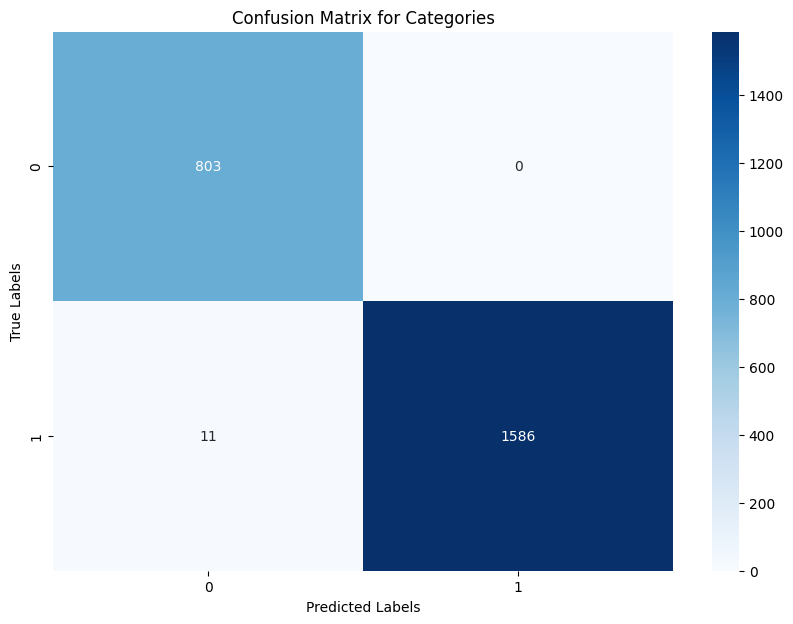

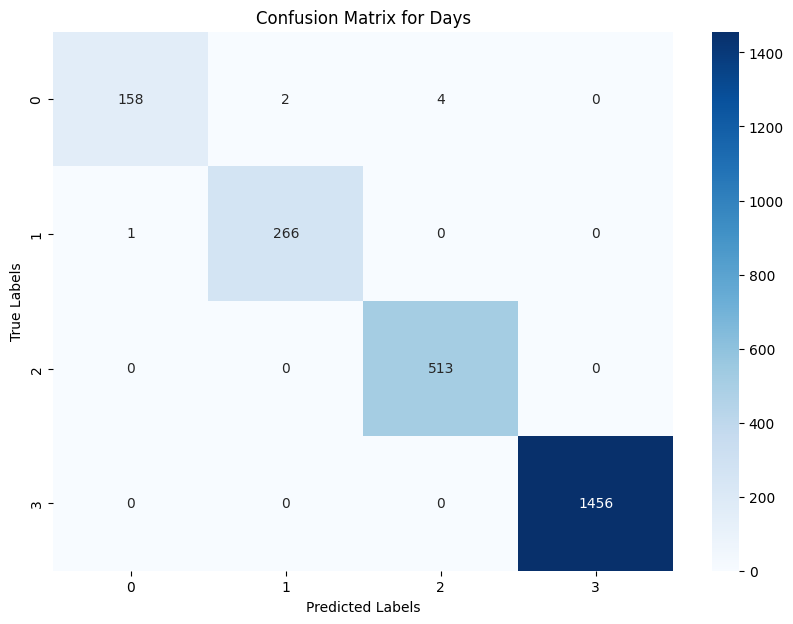

In [ ]:
# print(category_confusion_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(category_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Categories')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


print("=============================================")
# print(days_confusion_matrix)
# Plotting the confusion matrix for 'days'
plt.figure(figsize=(10, 7))
sns.heatmap(days_confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Days')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

def create_model(input_shape, num_classes_category, num_classes_days):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    
    category_output = Dense(num_classes_category, activation='softmax', name='category_output')(x)
    days_output = Dense(num_classes_days, activation='softmax', name='days_output')(x)
    
    model = Model(inputs=inputs, outputs=[category_output, days_output])
    
    return model

saved_model_path = 'cnn.h5'  
loaded_model = create_model(input_shape=(224, 224, 3), num_classes_category=2, num_classes_days=4)  
loaded_model.load_weights(saved_model_path)

image_path = r'dataset\4\Not Rotten\Image_13.jpg'  
target_size = (224, 224)
image = load_img(image_path, target_size=target_size)
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

category_pred, days_pred = loaded_model.predict(image)

category_labels = ['Not Rotten', 'Rotten']
days_labels = [str(i) for i in range(2, 6)]

predicted_category = category_labels[np.argmax(category_pred)]
predicted_days = days_labels[np.argmax(days_pred)]

print("Predicted Category:", predicted_category)
print("Predicted Days:", predicted_days)


1/1 [==============================] - 1s 655ms/step
Predicted Category: Not Rotten
Predicted Days: 4
